In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [9]:

tickers = ["RELIANCE.NS", "TCS.NS", "INFY.NS", "HDFCBANK.NS", "ICICIBANK.NS",
           "WIPRO.NS", "BAJAJFINSV.NS", "HCLTECH.NS", "KOTAKBANK.NS", "SBIN.NS"]

start = "2022-01-01"

In [10]:
raw = yf.download(tickers, start=start, progress=False)

/tmp/ipython-input-3781124709.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw = yf.download(tickers, start=start, progress=False)


In [11]:
if "Close" not in raw.columns:
    raise ValueError("No 'Close' column returned from yfinance. Try different tickers.")

data = raw["Close"].dropna()
print("Data Loaded Successfully!")
print(data.head())

Data Loaded Successfully!
Ticker      BAJAJFINSV.NS   HCLTECH.NS  HDFCBANK.NS  ICICIBANK.NS  \
Date                                                                
2022-01-03    1694.729004  1127.097900   722.802551    741.773987   
2022-01-04    1710.113159  1133.302368   727.035767    749.679565   
2022-01-05    1795.237305  1114.009521   744.301331    764.423828   
2022-01-06    1795.047729  1092.039429   732.362854    761.513855   
2022-01-07    1772.133667  1096.841431   737.499817    769.468018   

Ticker          INFY.NS  KOTAKBANK.NS  RELIANCE.NS     SBIN.NS       TCS.NS  \
Date                                                                          
2022-01-03  1704.249512   1817.761841  1093.780640  438.425720  3447.918457   
2022-01-04  1704.877930   1845.808594  1118.464966  450.252411  3508.427734   
2022-01-05  1655.953003   1915.103638  1123.697632  458.540405  3486.933105   
2022-01-06  1631.849609   1884.964600  1099.536621  457.888580  3438.615723   
2022-01-07  1628

In [12]:


rets = data.pct_change().dropna()

In [13]:
def max_drawdown(ts):
    cum = (1 + ts).cumprod()
    peak = cum.cummax()
    drawdown = (cum - peak) / peak
    return drawdown.min()

features = []

for t in tickers:
    series = rets[t].dropna()
    features.append({
        "ticker": t,
        "mean_return": series.mean() * 252,
        "volatility": series.std() * np.sqrt(252),
        "skewness": series.skew(),
        "max_drawdown": max_drawdown(series),
        "avg_corr": rets.corr()[t].mean()
    })

feat_df = pd.DataFrame(features).set_index("ticker")
feat_df = feat_df.fillna(feat_df.mean())


In [14]:

scaler = StandardScaler()
X = scaler.fit_transform(feat_df)


In [15]:

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

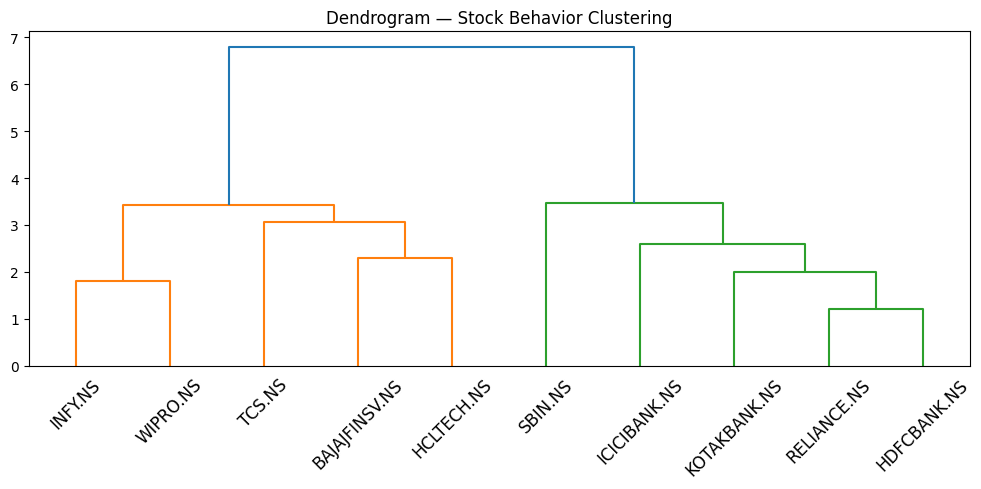

In [16]:
plt.figure(figsize=(10, 5))
linked = sch.linkage(X, method='ward')
sch.dendrogram(linked, labels=feat_df.index, leaf_rotation=45)
plt.title("Dendrogram — Stock Behavior Clustering")
plt.tight_layout()
plt.show()


In [17]:


n_clusters = 4
hc = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
labels = hc.fit_predict(X)
feat_df["cluster"] = labels

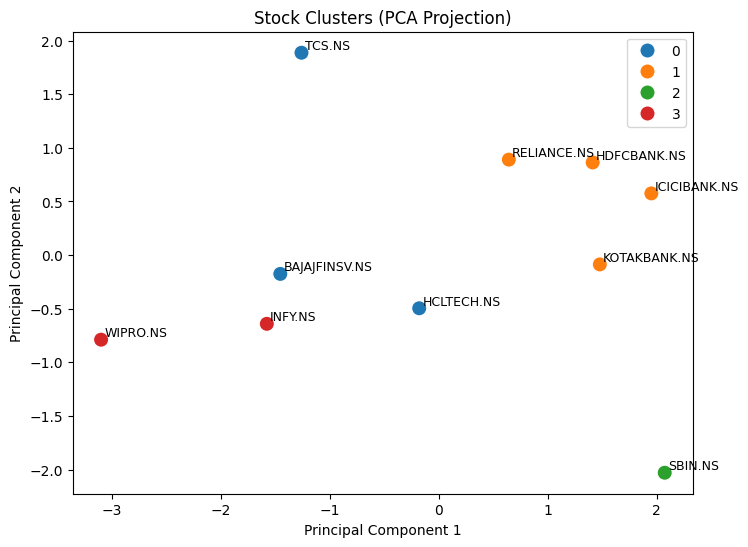

In [18]:

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels, palette="tab10", s=120)

for i, name in enumerate(feat_df.index):
    plt.text(X_pca[i,0]+0.03, X_pca[i,1]+0.03, name, fontsize=9)

plt.title("Stock Clusters (PCA Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


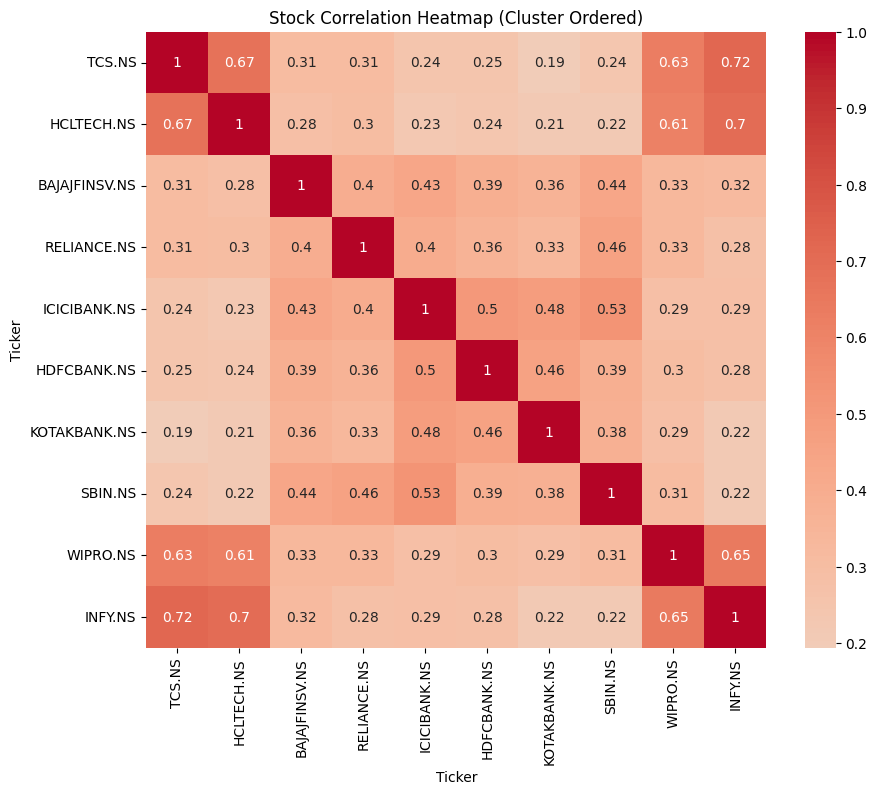

In [19]:
order = feat_df.sort_values("cluster").index
plt.figure(figsize=(10,8))
sns.heatmap(rets[order].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Stock Correlation Heatmap (Cluster Ordered)")
plt.show()


In [20]:
print("\n===== STOCK CLUSTERS =====")
for c in sorted(feat_df["cluster"].unique()):
    print(f"\nCluster {c}:")
    print(list(feat_df[feat_df["cluster"] == c].index))

print("\n===== CLUSTER SUMMARY =====")
print(feat_df.groupby("cluster").mean().round(4))



===== STOCK CLUSTERS =====

Cluster 0:
['TCS.NS', 'BAJAJFINSV.NS', 'HCLTECH.NS']

Cluster 1:
['RELIANCE.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'KOTAKBANK.NS']

Cluster 2:
['SBIN.NS']

Cluster 3:
['INFY.NS', 'WIPRO.NS']

===== CLUSTER SUMMARY =====
         mean_return  volatility  skewness  max_drawdown  avg_corr
cluster                                                           
0             0.0734      0.2365    0.1311       -0.3599    0.4429
1             0.1174      0.2104   -0.1467       -0.2321    0.4157
2             0.2294      0.2413   -0.6451       -0.2394    0.4169
3            -0.0135      0.2514   -0.1861       -0.4279    0.4702
